## Семинар 4: "Сверточные сети"

ФИО: Елохов Артур Владимирович

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [2]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal)-len(kernel)+1)
    # 1. не забудьте перевернуть ядро!
    # 2. необходимо реализовать свертку без отступов, т.е. 
    #   размер результирующего сигнала должен быть меньше входного.
    
    ##### YOUR CODE HERE #####
    for k in xrange(len(signal_convolved)):
        signal_convolved[k] = np.dot(signal[k:k+len(kernel)], kernel[::-1])
    
    
    return signal_convolved

Проверим правильность реализации, сравнив с реализацией из scipy

In [3]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)

t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

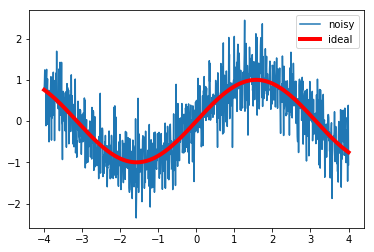

In [4]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [5]:
denoised_signal = t_convolve(noisy_signal, np.array([0.2, 0.2, 0.2, 0.2, 0.2]))

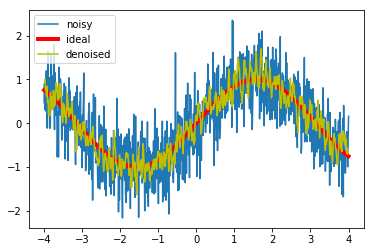

In [6]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x[2:-2], denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

In [7]:
### YOUR CODE HERE #####
kernel = 1.0/101.0 * np.ones(101)
denoised_signal = t_convolve(noisy_signal, kernel)

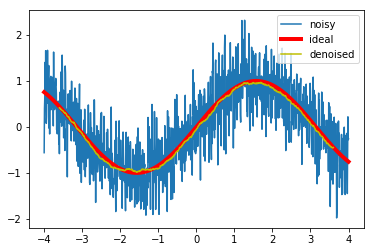

In [8]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x[50:-50], denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

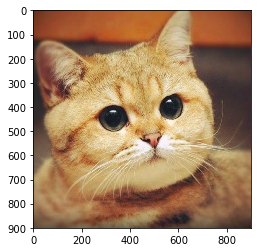

In [9]:
image = plt.imread('kot.jpg')
plt.imshow(image)

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [10]:
image.shape

(900, 900, 3)

In [11]:
kernel = np.zeros((3, 3, 3))
kernel[1,1,0] = 299.0/1000.0
kernel[1,1,1] = 587.0/1000.0
kernel[1,1,2] = 114.0/1000.0
print kernel

[[[ 0.     0.     0.   ]
  [ 0.     0.     0.   ]
  [ 0.     0.     0.   ]]

 [[ 0.     0.     0.   ]
  [ 0.299  0.587  0.114]
  [ 0.     0.     0.   ]]

 [[ 0.     0.     0.   ]
  [ 0.     0.     0.   ]
  [ 0.     0.     0.   ]]]


In [12]:
color_to_bw = convolve(image, kernel, mode='valid')

In [13]:
print color_to_bw.shape

(898, 898, 1)


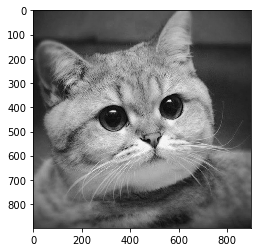

In [14]:
plt.imshow(color_to_bw.reshape((image.shape[0]-2, image.shape[1]-2)).astype('uint8'), cmap='gray')

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

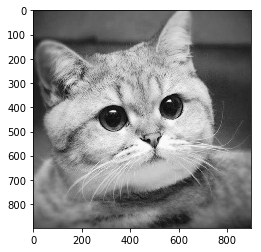

In [15]:
bw_image = color_to_bw.reshape((image.shape[0]-2, image.shape[1]-2)).astype('uint8')
# Не забудьте, что размер bw_image должен быть [w,h], а convolve вам вернет [w,h,1]
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро фильтра Собеля и продемонстрируйте результат его применения к любому цветному изображению.</i>

In [16]:
sobel_x = np.zeros((3,3,3))
sobel_x[0,0,:] = sobel_x[2,0,:] = -1
sobel_x[0,2,:] = sobel_x[2,2,:] = 1
sobel_x[1,0,:] = -2
sobel_x[1,2,:] = 2
print sobel_x

[[[-1. -1. -1.]
  [ 0.  0.  0.]
  [ 1.  1.  1.]]

 [[-2. -2. -2.]
  [ 0.  0.  0.]
  [ 2.  2.  2.]]

 [[-1. -1. -1.]
  [ 0.  0.  0.]
  [ 1.  1.  1.]]]


In [17]:
sobel_y = np.zeros((3,3,3))
sobel_y[0,0,:] = sobel_y[0,2,:] = 1
sobel_y[2,0,:] = sobel_y[2,2,:] = -1
sobel_y[2,1,:] = -2
sobel_y[0,1,:] = 2
print sobel_y

[[[ 1.  1.  1.]
  [ 2.  2.  2.]
  [ 1.  1.  1.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[-1. -1. -1.]
  [-2. -2. -2.]
  [-1. -1. -1.]]]


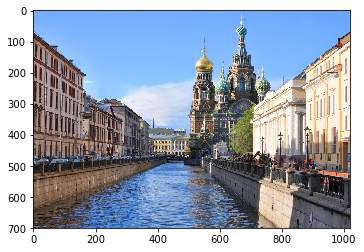

In [18]:
image2 = plt.imread('piter.jpg')
plt.imshow(image2)

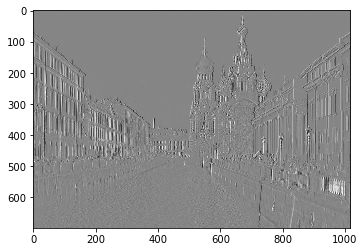

In [19]:
plt.imshow(convolve(image2, sobel_x, mode='valid').reshape((image2.shape[0]-2, image2.shape[1]-2)), cmap='gray')

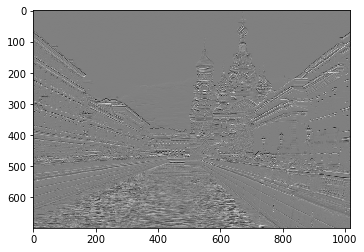

In [20]:
plt.imshow(convolve(image2, sobel_y, mode='valid').reshape((image2.shape[0]-2, image2.shape[1]-2)), cmap='gray')

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [21]:
def t_convolve_bank(signal, kernel):
    assert signal.ndim == kernel.ndim - 1
    ##### YOUR CODE HERE #####
    tmp = convolve(signal, kernel[0], mode='valid')
    tmp = tmp.reshape(tmp.shape[:-1])
    result = np.zeros((tmp.shape + (kernel.shape[0],)))
    result[..., 0] = tmp
    for i in xrange(1, kernel.shape[0]):
        result[..., i] = convolve(signal, kernel[i], mode='valid').reshape(tmp.shape)
    return result

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [22]:
##### YOUR CODE HERE #####
rgb_to_bgr = np.zeros((3,1,1,3))
rgb_to_bgr[0,:,:,:2] = 1
rgb_to_bgr[1,:,:,:1] = 1
rgb_to_bgr[2,:,:,:0] = 1

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

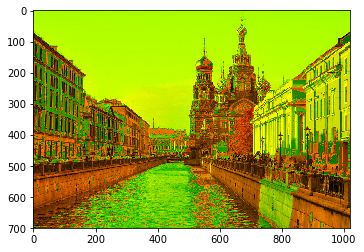

In [23]:
##### YOUR CODE HERE #####
# Не забудьте, что после свертки вы скорее всего получите тензор типа float. 
# Чтобы imshow нормально отобразил результат, надо привести его к типу uint8 (нпр., при помощи .astype('uint8'))
new_img = t_convolve_bank(image2, rgb_to_bgr)
plt.imshow(new_img.astype('uint8'))

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [24]:
X = np.zeros((3,3,3))
X[1,1,2] = 3
X[2,1,0] = 2
X[0,1,0] = 5
print X
print np.max(X, axis=0)

[[[ 0.  0.  0.]
  [ 5.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  3.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 2.  0.  0.]
  [ 0.  0.  0.]]]
[[ 0.  0.  0.]
 [ 5.  0.  3.]
 [ 0.  0.  0.]]


In [25]:
def maxpool(image):
    assert(image.ndim == 3)
    ##### YOUR CODE HERE #####
    result = np.zeros((image.shape[0]/2, image.shape[1]/2, image.shape[2]))
    k = 0
    for i in xrange(image.shape[0]/2):
        l = 0
        for j in xrange(image.shape[1]/2):
            result[k, l] = np.max(image[2*i:2*i+2,2*j:2*j+2,:], axis=(0,1))
            l += 1
        k += 1
    return result

def medianpool(image):
    assert(image.ndim == 3)
    ##### YOUR CODE HERE #####
    result = np.zeros((image.shape[0]/2, image.shape[1]/2, image.shape[2]))
    k = 0
    for i in xrange(image.shape[0]/2):
        l = 0
        for j in xrange(image.shape[1]/2):
            result[k, l] = np.median(image[2*i:2*i+2,2*j:2*j+2,:], axis=(0,1))
            l += 1
        k += 1
    return result

Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

In [26]:
def salt_and_pepper(image):
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.01
    out = np.copy(image)
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape[:-1]]
    out[coords] = 255

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape[:-1]]
    out[coords] = 0
    return out

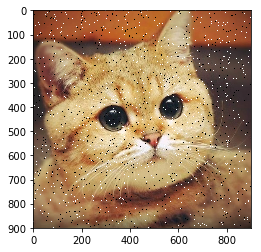

In [27]:
##### YOUR CODE HERE #####
noised_img = salt_and_pepper(image)
plt.imshow(noised_img)

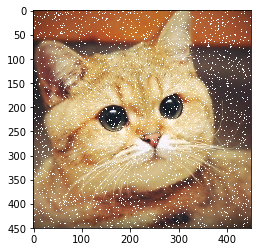

In [28]:
plt.imshow(maxpool(noised_img).astype('uint8'))

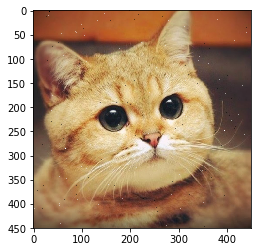

In [29]:
plt.imshow(medianpool(noised_img).astype('uint8'))

<i>2.3 Какой тип пулинга лучше справился с поставленной задачей? Почему?</i>

Медианный, потому что maxpool увеличивает число "соли"

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 conv 3x3 -> ReLU -> maxpool -> 16 conv 3x3 -> ReLU -> ravel -> linear -> softmax
1. input -> 8 conv 3x3 -> ReLU -> 16 conv 3x3 -> ReLU -> maxpool -> 32 conv 3x3 -> ravel -> linear -> softmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [2]:
from sklearn.metrics import accuracy_score, mean_squared_error

In [3]:
to_numpy = lambda x: x.numpy()
train_dataset = MNIST('.', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('.', train=False, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [4]:
for X, y in train_loader:
    images_train = X
    labels_train = y
    break

In [5]:
# пример сверточной сети
image_size = images_train.size(2)
channels = images_train.size(1)
class myConvNet(nn.Module):
    def __init__(self):
        super(myConvNet, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 3, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(image_size/2*image_size/2*3, 10), nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [6]:
# пример forward pass
network = myConvNet()
batch_size = 10
X = Variable(images_train[:batch_size])
y = Variable(labels_train[:batch_size], requires_grad=False)
output = network.forward(X)

In [7]:
# а вот так можно сделать шаг обучения на этом батче
loss_fn = torch.nn.NLLLoss()

# о разных методах оптимизации мы поговорим на лекции 6
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 

loss = loss_fn(output, y)
print 'Current loss:', loss.data[0]

optimizer.zero_grad()
loss.backward()
optimizer.step()

Current loss: 2.30792307854


<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

In [8]:
image_size = images_train.size(2)
channels = images_train.size(1)
class ConvNet_1(nn.Module):
    def __init__(self):
        super(ConvNet_1, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1), 
                                         nn.ReLU(), 
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, 3, padding=1),
                                         nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(image_size/2*image_size/2*16, 10), nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
    
class ConvNet_2(nn.Module):
    def __init__(self):
        super(ConvNet_2, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1), 
                                         nn.ReLU(),
                                         nn.Conv2d(8, 16, 3, padding=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(16, 32, 3, padding=1))
        self.linear_layers = nn.Sequential(nn.Linear(image_size/2*image_size/2*32, 10), nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [9]:
def apply_model(model, train, test, Epoch=10, learning_rate=0.001):
    Loss_train = []
    Loss_test = []
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in xrange(Epoch):
        print "Epoch : %d" %(epoch + 1)
        L_train = []
        L_test = []
        k = 0
        for X, y in train:
            X_var = Variable(X)
            y_var = Variable(y, requires_grad=False)
            y_pred = model(X_var)
            loss = loss_fn(y_pred, y_var)
            if(k % 300 == 0):
                print 'Current loss:', loss.data[0]
            L_train.append(loss.data[0])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            k += 1
        for X, y in test:
            X_var = Variable(X)
            y_var = Variable(y, requires_grad=False)
            y_pred = model(X_var)
            loss = loss_fn(y_pred, y_var)
            L_test.append(loss.data[0])
        Loss_train.append(sum(L_train)/len(L_train))
        Loss_test.append(sum(L_test)/len(L_test))
    axis_x = np.arange(1, Epoch + 1)
    axis_y1 = np.array(Loss_train)
    axis_y2 = np.array(Loss_test)
    with plt.style.context(('ggplot')):
        plt.figure(figsize=(20,8))
        plt.plot(axis_x, axis_y1, linewidth=2.0)
        plt.plot(axis_x, axis_y2, linewidth=2.0)
        plt.xlabel('Epoch')
        plt.ylabel('NLL')
        plt.legend(['train', 'test'])
        plt.show()
    Scores = []
    for X, y in test:
        X_var = Variable(X)
        y_var = Variable(y, requires_grad=False)
        y_predicted = model(X_var)
        Scores.append(accuracy_score(y.numpy(), np.argmax(y_predicted.data.numpy(), axis=1)))
    print("Accuracy: %f" %(sum(Scores)/len(Scores)))
    return

Epoch : 1
Current loss: 2.31758403778
Current loss: 0.369628459215
Current loss: 0.403461009264
Current loss: 0.125247359276
Current loss: 0.0186310559511
Current loss: 0.172225147486
Current loss: 0.0365436263382
Epoch : 2
Current loss: 0.129557132721
Current loss: 0.0128518091515
Current loss: 0.0626818910241
Current loss: 0.131666019559
Current loss: 0.268951445818
Current loss: 0.0270021371543
Current loss: 0.0635199472308
Epoch : 3
Current loss: 0.0217421762645
Current loss: 0.00693763326854
Current loss: 0.0210210364312
Current loss: 0.0024544657208
Current loss: 0.0101355453953
Current loss: 0.0441274568439
Current loss: 0.0170986130834
Epoch : 4
Current loss: 0.013676667586
Current loss: 0.0178405679762
Current loss: 0.0236346106976
Current loss: 0.111481845379
Current loss: 0.000470674451208
Current loss: 0.0327585078776
Current loss: 0.0009448719793
Epoch : 5
Current loss: 0.00420113047585
Current loss: 0.0601383671165
Current loss: 0.0265472047031
Current loss: 0.00272077275

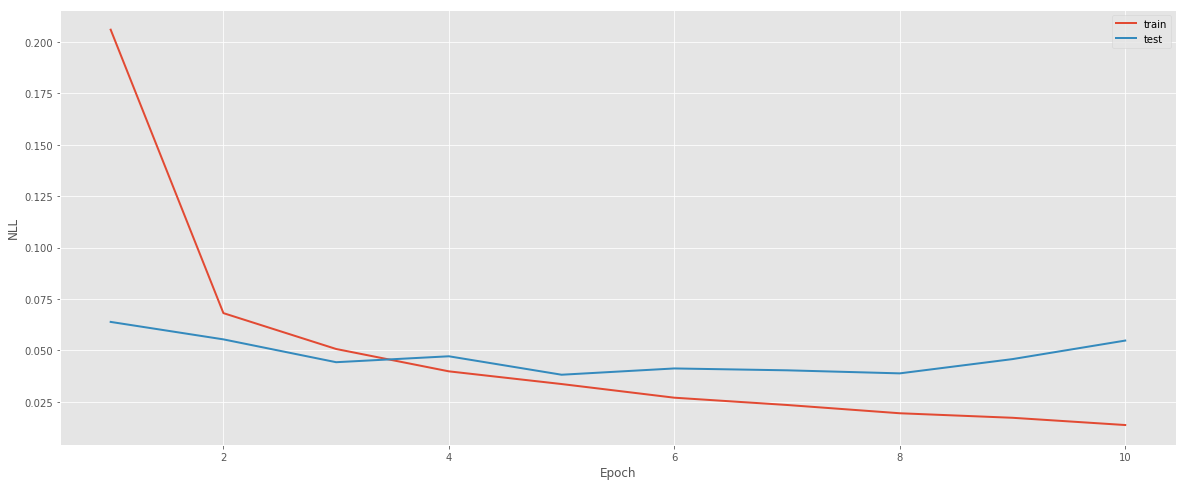

Accuracy: 0.984924


In [38]:
loss_fn = torch.nn.NLLLoss()
model = ConvNet_1()
apply_model(model, train_loader, test_loader)

Epoch : 1
Current loss: 2.31185746193
Current loss: 0.133928433061
Current loss: 0.192138403654
Current loss: 0.279092043638
Current loss: 0.010139586404
Current loss: 0.00836870074272
Current loss: 0.0597700960934
Epoch : 2
Current loss: 0.103407688439
Current loss: 0.0445794798434
Current loss: 0.283250451088
Current loss: 0.0199258793145
Current loss: 0.324719548225
Current loss: 0.0209784321487
Current loss: 0.0093097537756
Epoch : 3
Current loss: 0.0123273832723
Current loss: 0.01195483841
Current loss: 0.0319017395377
Current loss: 0.0672489851713
Current loss: 0.0530599094927
Current loss: 0.00346346455626
Current loss: 0.000961313082371
Epoch : 4
Current loss: 0.00713077373803
Current loss: 0.00486042164266
Current loss: 0.0296766422689
Current loss: 0.13195566833
Current loss: 0.00171153724659
Current loss: 0.0745790824294
Current loss: 0.0409295223653
Epoch : 5
Current loss: 0.0157056041062
Current loss: 0.000666285632178
Current loss: 0.00269720028155
Current loss: 0.0084537

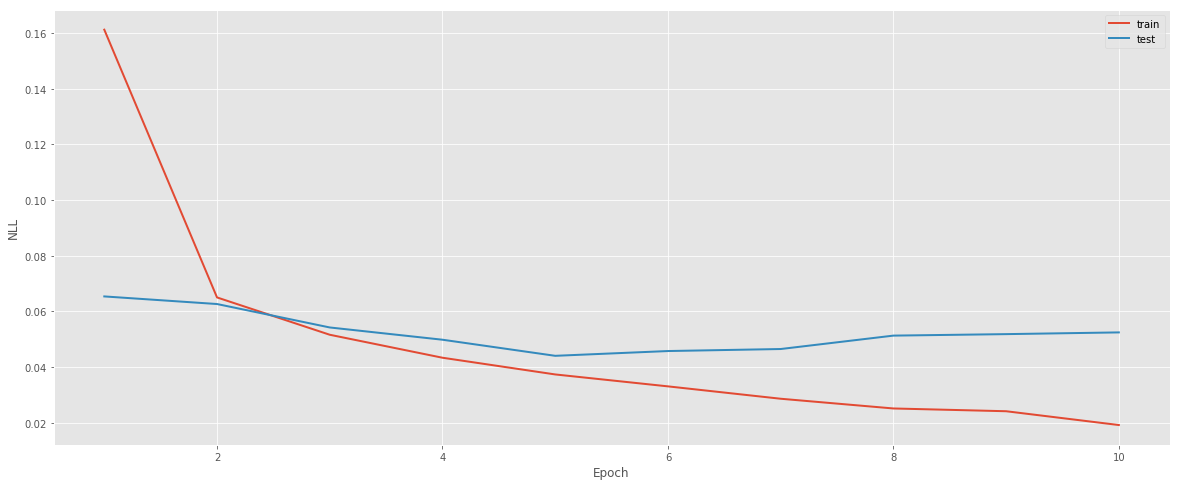

Accuracy: 0.985323


In [39]:
model = ConvNet_2()
apply_model(model, train_loader, test_loader, learning_rate=0.001)

Качество на полносвязной сети: 0.975339

<i>3.2 На каких объектах сеть ошибается сильнее всего?</i>

In [40]:
##### YOUR CODE HERE #####
test = DataLoader(test_dataset)
X_failed = []
for X, y in test:
    y_predicted = model(Variable(X))
    if(y.numpy() != np.argmax(y_predicted.data.numpy(), axis=1)):
        X = X.view(X.size(0), -1)
        X = X.numpy()
        X_failed.append(X)

In [41]:
len(X_failed)

147

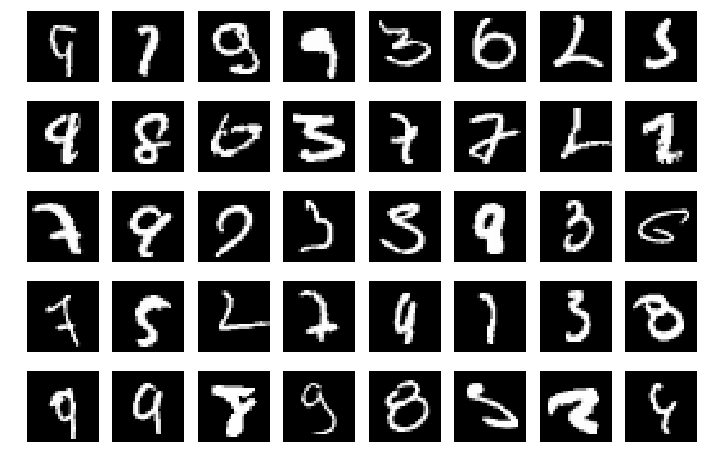

In [42]:
plt.figure(figsize=(12, 8))
for i in range(40):
    plt.subplot(5, 8, i+1)
    plt.imshow(X_failed[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

In [43]:
class ConvNet_3(nn.Module):
    def __init__(self):
        super(ConvNet_3, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 16, 3, padding=1), 
                                         nn.ReLU(),
                                         nn.Conv2d(16, 32, 3, padding=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(32, 128, 3, padding=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(128, 256, 3, padding=1),
                                         nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(image_size/4*image_size/4*256, 10), nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch : 1
Current loss: 2.30802941322
Current loss: 0.0340513661504
Current loss: 0.0202633105218
Current loss: 0.108577154577
Current loss: 0.00403865193948
Current loss: 0.0166668221354
Current loss: 0.00356717570685
Epoch : 2
Current loss: 0.230117961764
Current loss: 0.00144411507063
Current loss: 0.000416191469412
Current loss: 0.0034044587519
Current loss: 0.323851644993
Current loss: 0.000585203408264
Current loss: 0.00239615817554
Epoch : 3
Current loss: 0.00453392183408
Current loss: 0.00504449894652
Current loss: 0.00623699789867
Current loss: 0.0300417225808
Current loss: 0.00174346193671
Current loss: 0.000191388171515
Current loss: 0.0675167813897
Epoch : 4
Current loss: 0.000271560507827
Current loss: 0.00286825350486
Current loss: 0.0359412543476
Current loss: 0.000488440331537
Current loss: 0.0658729150891
Current loss: 0.00241089216433
Current loss: 0.00519316783175
Epoch : 5
Current loss: 0.00136064586695
Current loss: 0.0118751302361
Current loss: 0.0150967203081
Cur

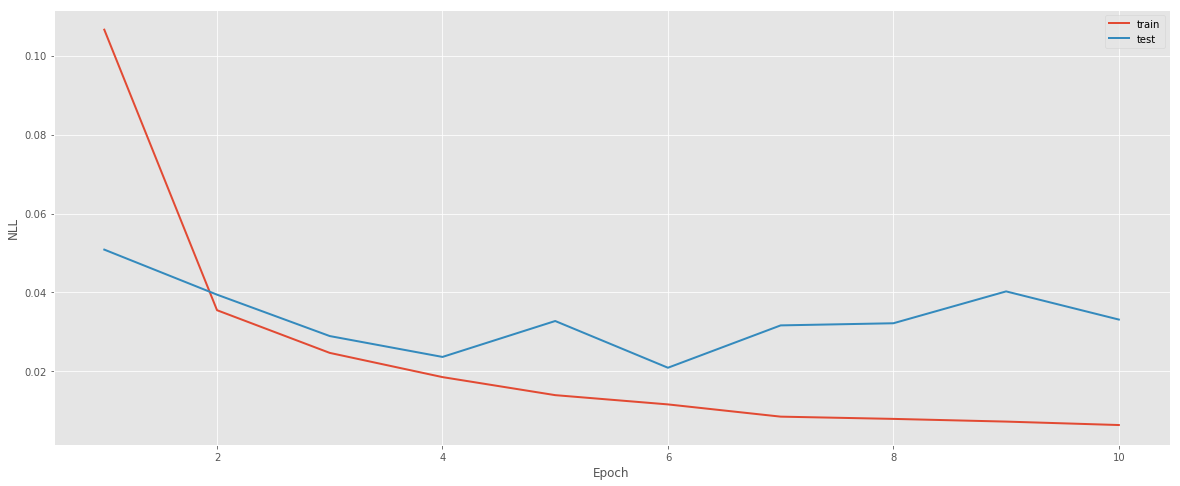

Accuracy: 0.993411


In [44]:
model = ConvNet_3()
apply_model(model, train_loader, test_loader, learning_rate=0.001)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: